## FizzBuzz with Neural Networks - [source](https://joelgrus.com/2016/05/23/fizz-buzz-in-tensorflow/)
### [Glitched Failure Video](https://youtu.be/_s8nPRddxp8)

The "FizzBuzz" problem is a classic coding challenge. Here's a standard approach:

In [13]:
def fizzbuzz(n):
    FIZZ = "Fizz"
    BUZZ = "Buzz"
    FIZZBUZZ = FIZZ + BUZZ
    
    is_div_by_3 = n % 3 == 0
    is_div_by_5 = n % 5 == 0
    
    if is_div_by_3 & is_div_by_5:
        return FIZZBUZZ
    if is_div_by_3:
        return FIZZ
    if is_div_by_5:
        return BUZZ
    return n

In [14]:
## TESTING ##
for i in range(1,16):
    print(fizzbuzz(i))

1
2
Fizz
4
Buzz
Fizz
7
8
Fizz
Buzz
11
Fizz
13
14
FizzBuzz


That's very...simple.

__Let's kick things up a notch by training a neural network to LEARN FizzBuzz!__

Here's a random unrelated image.
<img src="https://pbs.twimg.com/media/D3EwYFrX0AEnCJP.jpg">

The aim here is to build an overly complicated black box function (neural network), that works much like our original `fizzbuzz` function; __it takes a number input and returns the appropriate value: the input number, "Fizz", "Buzz", or "FizzBuzz".__

## Imports

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

## Generating "data"
Neural networks need a LOT of data, so let's generate 1 million data points!

In [16]:
df = pd.DataFrame()
n = 1_000_000

# generating data
df["numbers"] = range(1, n + 1)
df["fizzbuzz_numbers"] = df["numbers"].map(fizzbuzz) # reusing fizzbuzz function to get correct answer

In [17]:
df.head(10)

,numbers,fizzbuzz_numbers
0,1,1
1,2,2
2,3,Fizz
3,4,4
4,5,Buzz
5,6,Fizz
6,7,7
7,8,8
8,9,Fizz
9,10,Buzz


Our neural networks "answer" needs to be either a _continuous number_ or a _discrete category._ Right now we have a mix of strings and numbers, which is no good! 

Let's focus on a categorical output, so we'll want to __map our "answer" to a proper categorical target:__
```
0 will represent the answer is the original number
1 will represent "Fizz"
2 will represent "Buzz"
3 will represent "FizzBuzz"
```

In [18]:
def convert_fizzbuzz(val):
    if type(val) == int:
        return 0
    return ["Fizz", "Buzz", "FizzBuzz"].index(val) + 1

In [19]:
df["target"] = df["fizzbuzz_numbers"].map(convert_fizzbuzz)

In [20]:
df.head(10)

,numbers,fizzbuzz_numbers,target
0,1,1,0
1,2,2,0
2,3,Fizz,1
3,4,4,0
4,5,Buzz,2
5,6,Fizz,1
6,7,7,0
7,8,8,0
8,9,Fizz,1
9,10,Buzz,2


Our target isn't the only thing that will need some work. The input matters, too!

Keep in mind, neural networks fundamentally use hidden layers to understand the structure and connections within the input given. Currently, our input is a raw number, which lacks any real structure or connections!

So, let's help our neural network out by giving it more "surface area" to work with and __break our input numbers down into a consistent binary form. This will allow the neural network to better grasp the mathematical relationships within the input number.__

In [21]:
def binary_encode(i, num_digits):
    '''Returns an binary array of the given number of size `num_digits`'''
    return np.array([i >> d & 1 for d in range(num_digits - 1,-1,-1)])

In [22]:
# example, let's create the binary representation of the number 10 using 5 elements
binary_encode(10, 5)

array([0, 1, 0, 1, 0])

$$
\text{01010}
$$
$$
= (0\times2^4)+(1\times2^3)+(0\times2^2)+(1\times2^1)+(0\times2^0)
$$
$$= 0 + 8 + 0 + 2 + 0 = 10$$

[_Learn more about binary representations here_](https://en.wikipedia.org/wiki/Binary_number)

In [24]:
# Since our upper limit is 1,000,000...
binary_encode(1_000_000, 21)

array([0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0])

...we'll need to use at most 20 elements!

So, to recap: __our neural network with take in a binary representation of a number (ex, [...0,1,0,1,0], which represents 10), and return the categorical representation (ex. 2, which represents "Buzz")__

## Model Preparation

In [26]:
num_of_binary_digits = 20 # captures 1 million

# full input (X) and full target (y)
X = np.array([binary_encode(num, num_of_binary_digits) for num in df["numbers"]])
y = to_categorical(df["target"]) # needed for keras implementation

In [27]:
# What does the target look like now?
y[:15]

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [28]:
# index coincides with categorical target, so we can take the "argmax" to work backwards
df["target"][:15].values

array([0, 0, 1, 0, 2, 1, 0, 0, 1, 2, 0, 1, 0, 0, 3], dtype=int64)

We'll want to split up our data into a training and testing set.

Let's use the first 100 digits for testing and train on the rest of the data.

In [45]:
# Creating train/test split
X_train = X[100:] 
X_test = X[:100]
y_train = y[100:]
y_test = y[:100]

In [46]:
# Check out training input (X_train)
X_train[:10]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0]])

In [48]:
# Check out training target (y_train)
y_train[:10]

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)

## Modeling
Let's build a very simple model:
- Input layer has shape of 20 (`num_of_binary_digits`) nodes
- 1st hidden layer connects the previous 20 nodes to 128 nodes w/relu activation
- 2nd hidden layer connects the previous 128 nodes to 64 nodes w/relu activation
- The output layer connects the previous 64 nodes to 4 output nodes (must be 4, which each represent one of the 4 possible categories) with softmax activation (to make it categorical)

In [63]:
model = Sequential([
    Dense(128, input_shape = (num_of_binary_digits,), activation='relu'),
    Dense(64, activation='relu'),
    Dense(4, activation = "softmax")
])

We'll use categotical crossentropy for loss and optimize using Adam

In [64]:
model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])

Let's also no drag on the process too long by stopping early once we don't see much change.

In [65]:
callback = EarlyStopping(monitor = 'loss', patience = 3)

Now, let's train the model using our training data and validate using our testing data.

In [66]:
history = model.fit(
    X_train, 
    y_train, 
    validation_data = (X_test, y_test), 
    epochs=20,
    batch_size = 128, 
    callbacks=[callback]
)

Epoch 1/20
7812/7812 [==============================] - 15s 2ms/step - loss: 1.1091 - accuracy: 0.5459 - val_loss: 0.5434 - val_accuracy: 0.8700
Epoch 2/20
7812/7812 [==============================] - 15s 2ms/step - loss: 0.4188 - accuracy: 0.8462 - val_loss: 0.0274 - val_accuracy: 1.0000
Epoch 3/20
7812/7812 [==============================] - 15s 2ms/step - loss: 0.1129 - accuracy: 0.9651 - val_loss: 0.0051 - val_accuracy: 1.0000
Epoch 4/20
7812/7812 [==============================] - 16s 2ms/step - loss: 0.0698 - accuracy: 0.9742 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 5/20
7812/7812 [==============================] - 15s 2ms/step - loss: 0.0523 - accuracy: 0.9797 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 6/20
7812/7812 [==============================] - 16s 2ms/step - loss: 0.0381 - accuracy: 0.9858 - val_loss: 4.4817e-04 - val_accuracy: 1.0000
Epoch 7/20
7812/7812 [==============================] - 24s 3ms/step - loss: 0.0288 - accuracy: 0.9903 - val_loss: 7.5910e-04 

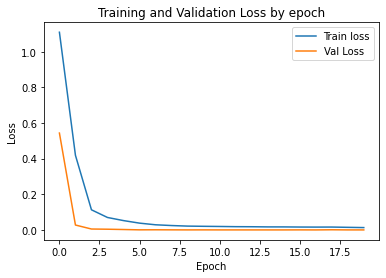

In [67]:
plt.title("Training and Validation Loss by epoch")
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend();

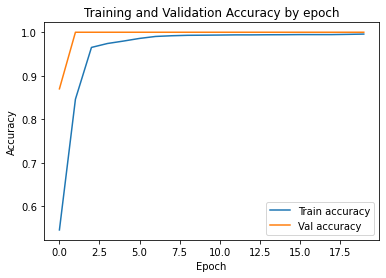

In [69]:
plt.title("Training and Validation Accuracy by epoch")
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend();

## Model Evaluation
Let's check out how our good our model is at predicting the correct answer for our test set (the numbers 1 - 100).

In [70]:
preds = model.predict(X_test)
preds[:10]

array([[1.0000000e+00, 4.5998977e-10, 9.0219013e-12, 8.1531628e-26],
       [1.0000000e+00, 2.4571192e-17, 3.1160635e-14, 4.9226543e-25],
       [8.7771831e-11, 1.0000000e+00, 3.9528674e-26, 7.3529226e-23],
       [1.0000000e+00, 1.0945666e-08, 2.8178227e-16, 9.5136563e-21],
       [9.9090035e-11, 4.0342241e-14, 1.0000000e+00, 1.6194349e-10],
       [1.2035140e-11, 1.0000000e+00, 2.8817308e-16, 1.6451986e-09],
       [1.0000000e+00, 2.1478204e-08, 1.1341265e-10, 1.9617491e-21],
       [1.0000000e+00, 7.7065297e-16, 3.8581594e-28, 0.0000000e+00],
       [3.1918607e-11, 9.9999940e-01, 5.1127994e-16, 5.7582514e-07],
       [2.0357496e-13, 1.9789368e-23, 1.0000000e+00, 1.3164477e-22]],
      dtype=float32)

This looks so messy! But remember, this output is set up so that the max argument coincides with the __category index__

In [71]:
argmax_preds = np.argmax(preds, axis = 1)
argmax_preds[:10]

array([0, 0, 1, 0, 2, 1, 0, 0, 1, 2], dtype=int64)

In [72]:
# the true values
df["target"].values[:10]

array([0, 0, 1, 0, 2, 1, 0, 0, 1, 2], dtype=int64)

In [73]:
# how well did the model do?
accuracy_score(df["target"].values[:100], argmax_preds)

1.0

Let's make sure to convert our output back to the expected values

In [74]:
def convert_prediction(input_val, prediction):
    return [input_val, "Fizz", "Buzz", "FizzBuzz"][prediction]

In [75]:
final = [convert_prediction(num, pred) for num, pred in zip(df["numbers"][:101], argmax_preds)]
final

[1,
 2,
 'Fizz',
 4,
 'Buzz',
 'Fizz',
 7,
 8,
 'Fizz',
 'Buzz',
 11,
 'Fizz',
 13,
 14,
 'FizzBuzz',
 16,
 17,
 'Fizz',
 19,
 'Buzz',
 'Fizz',
 22,
 23,
 'Fizz',
 'Buzz',
 26,
 'Fizz',
 28,
 29,
 'FizzBuzz',
 31,
 32,
 'Fizz',
 34,
 'Buzz',
 'Fizz',
 37,
 38,
 'Fizz',
 'Buzz',
 41,
 'Fizz',
 43,
 44,
 'FizzBuzz',
 46,
 47,
 'Fizz',
 49,
 'Buzz',
 'Fizz',
 52,
 53,
 'Fizz',
 'Buzz',
 56,
 'Fizz',
 58,
 59,
 'FizzBuzz',
 61,
 62,
 'Fizz',
 64,
 'Buzz',
 'Fizz',
 67,
 68,
 'Fizz',
 'Buzz',
 71,
 'Fizz',
 73,
 74,
 'FizzBuzz',
 76,
 77,
 'Fizz',
 79,
 'Buzz',
 'Fizz',
 82,
 83,
 'Fizz',
 'Buzz',
 86,
 'Fizz',
 88,
 89,
 'FizzBuzz',
 91,
 92,
 'Fizz',
 94,
 'Buzz',
 'Fizz',
 97,
 98,
 'Fizz',
 'Buzz']